In [10]:
import os
os.chdir('/homes/pr450/repos/research_projects/sampling_ddpm')

os.environ["CUDA_VISIBLE_DEVICES"]="1"

import torch

from tqdm import tqdm
from torch import Tensor as _T

from ddpm.model.main.multiepoch import MultiPreparatoryHVAEReverseProcess
from ddpm.tasks.main.base import DiffusionTask

from ddpm.utils.loading import generate_model_and_task_from_args_path_multiepoch
from purias_utils.util.logging import configure_logging_paths
from purias_utils.util.plotting import standard_swap_model_simplex_plots
from purias_utils.error_modelling_torus.non_parametric_error_model.setup_utils import setup_model_whole, WorkingMemoryFullSwapModel

from purias_utils.multiitem_working_memory.util.circle_utils import rectify_angles, polar2cart

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cmx
import matplotlib.colors as colors

from plane_alignment_utils import *


import numpy as np
from scipy.spatial.distance import pdist

In [11]:

base_dir_name = 'hvae_with_dendritic_20250410'

device = 'cuda'


In [12]:

# run_name = 'run_a2_probe_cued_rnn_no_swap_1'
# run_name = 'run_a3_probe_cued_diffusion_no_swap_1'

# run_name = 'run_a4_probe_cued_diffusion_flat_swap_1'
# run_name = 'run_a4b_probe_cued_diffusion_flat_less_swap_0'
# run_name = 'run_a4c_probe_cued_diffusion_flat_even_less_swap_0'

# run_name = 'run_a5_probe_cued_diffusion_cyclical_swap_1'
# run_name = 'run_a5b_probe_cued_diffusion_cyclical_less_swap_1'
run_name = 'run_a5c_probe_cued_diffusion_cyclical_less_swap_more_1'
# run_name = 'run_a5d_probe_cued_diffusion_cyclical_medium_swap_0'
# run_name = 'run_a5e_probe_cued_diffusion_cyclical_medium_less_swap_0'


#run_name = 'run_c2_index_cued_diffusion_no_swap_1'
#run_name = 'run_c3_index_cued_diffusion_0.05_swap_0'
#run_name = 'run_c3_index_cued_diffusion_0.1_swap_0'




_, task, ddpm_model, _, _ = generate_model_and_task_from_args_path_multiepoch(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/args.yaml', device)
ddpm_model.load_state_dict(torch.load(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/state.mdl', weights_only=True))
ddpm_model: MultiPreparatoryHVAEReverseProcess


for n, parameter in ddpm_model.named_parameters():
    parameter.required_grad = False


In [13]:
device = 'cuda'

emission_type = 'von_mises'
kernel_type = 'weiland'
trainable_kernel_delta = False
normalisation_inner = 'exp'
inducing_point_variational_parameterisation_type = 'gaussian'
init_min_seps = False
all_set_sizes = [2]
R_per_dim = 12
fix_inducing_point_locations = False
fix_non_swap = True
include_pi_1_tilde = False
#include_pi_u_tilde = False                      # XXX
#remove_uniform = True                           # XXX
include_pi_u_tilde = True
remove_uniform = False
monte_carlo_gp_samples = 1024
resume_path = None
shared_emission_distribution = False
shared_swap_function = False
swap_type = 'cue_dim_only'
symmetricality_constraint = True

min_sep = torch.pi / task.task_variable_gen.min_sep

num_models = 1

Initialising generative_model after 0 failed attempts at stability...


  0%|          | 0/10000 [00:00<?, ?it/s]

Fix simplex_plots to handle >1 models at the same time!, i.e. Q axis exists...


  0%|          | 13/10000 [00:02<30:35,  5.44it/s] 


KeyboardInterrupt: 

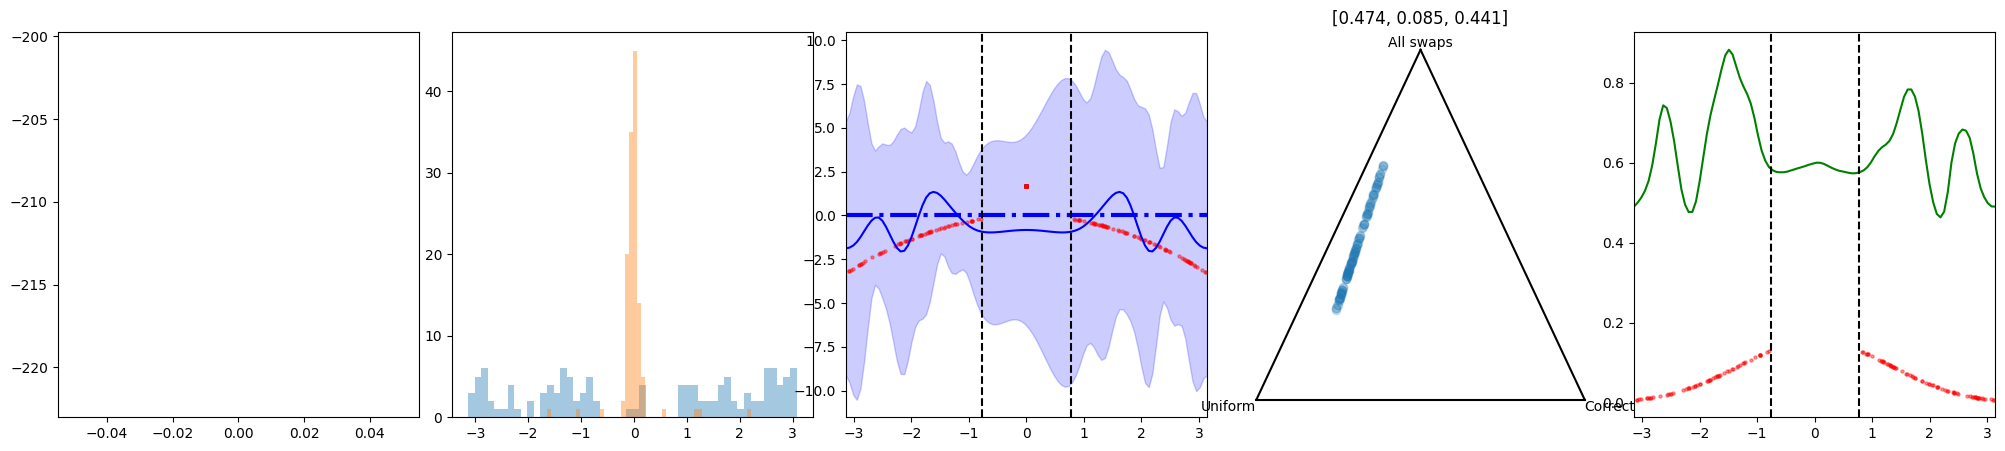

In [14]:
save_path = f'results_link_sampler/analysis/bns_fits_final/{run_name}'
try:
    os.mkdir(save_path)
except FileExistsError:
    pass




swap_model, D, delta_dimensions = setup_model_whole(
    num_models = num_models,
    swap_type = swap_type,
    kernel_type = kernel_type,
    emission_type = emission_type,
    all_set_sizes = all_set_sizes,
    remove_uniform = remove_uniform,
    include_pi_u_tilde = include_pi_u_tilde,
    trainable_kernel_delta = trainable_kernel_delta,
    R_per_dim = R_per_dim,
    fix_non_swap = fix_non_swap,
    include_pi_1_tilde = include_pi_1_tilde,
    fix_inducing_point_locations = fix_inducing_point_locations,
    symmetricality_constraint = symmetricality_constraint,
    shared_swap_function = shared_swap_function,
    shared_emission_distribution = shared_emission_distribution,
    all_min_seps = torch.tensor([[min_sep, min_sep]]),
    inducing_point_variational_parameterisation_type=inducing_point_variational_parameterisation_type,
    normalisation_inner= normalisation_inner,
    num_variational_samples = monte_carlo_gp_samples,
    num_importance_sampling_samples = monte_carlo_gp_samples,
    device=device,
    resume_path = None,
)


try:
    swap_model.generative_model.swap_function.fixed_pi_1_tilde = task.task_variable_gen.swap_function_offset
except AttributeError:
    swap_model.generative_model.swap_function.fixed_pi_1_tilde = 0.0


# swap_model.generative_model.swap_function._fixed_pi_1_tilde


batch_size = 128
num_samples = 1
flip_augmentation = True

opt = torch.optim.Adam(swap_model.parameters(), lr = 0.01)

swap_model.cuda()

all_llh = []


infinite_data_mode = True


for i in tqdm(range(10_000)):

    if infinite_data_mode or i == 0:

        trial_information = task.generate_trial_information(batch_size=batch_size, num_samples=num_samples)

        with torch.no_grad():
            novel_samples_prep_dicts, novel_samples_dict = ddpm_model.generate_samples(
                # prep_network_inputs=[
                #     pni[[0]] for pni in trial_information.prep_network_inputs
                # ],
                # diffusion_network_inputs=[
                #     dni[[0]] for dni in trial_information.diffusion_network_inputs
                # ],
                prep_network_inputs = trial_information.prep_network_inputs,
                diffusion_network_inputs = trial_information.diffusion_network_inputs,
                prep_epoch_durations=trial_information.prep_epoch_durations,
                diffusion_epoch_durations=trial_information.diffusion_epoch_durations,
                samples_shape=[batch_size, num_samples],
                noise_scaler=1.0,
            )


        cued_idx = trial_information.task_variable_information['cued_item_idx']

        all_probe_values = rectify_angles(trial_information.task_variable_information['probe_features'])
        probe_values = torch.zeros_like(all_probe_values)
        probe_values[torch.arange(batch_size),0] = all_probe_values[torch.arange(batch_size),cued_idx]
        probe_values[torch.arange(batch_size),1] = all_probe_values[torch.arange(batch_size),1-cued_idx]
        probe_deltas = rectify_angles(probe_values - probe_values[:,[0]])
        deltas_batch = probe_deltas.unsqueeze(-1).unsqueeze(0).repeat_interleave(num_models, 0)

        all_report_values = rectify_angles(trial_information.task_variable_information['report_features'])
        report_values = torch.zeros_like(all_report_values)
        report_values[torch.arange(batch_size),0] = all_report_values[torch.arange(batch_size),cued_idx]
        report_values[torch.arange(batch_size),1] = all_report_values[torch.arange(batch_size),1-cued_idx]

        responses_cart = novel_samples_dict['samples'].squeeze(1)
        responses = torch.arctan2(responses_cart[:,1], responses_cart[:,0]).unsqueeze(-1)

        errors = rectify_angles(responses - report_values)
        errors_batch = errors.unsqueeze(0).repeat_interleave(num_models, 0)


    if flip_augmentation:
        augmentation_map_deltas = (2 * (torch.rand_like(deltas_batch) < 0.5).int()) - 1
        deltas_batch = deltas_batch * augmentation_map_deltas.to(dtype = deltas_batch.dtype, device = deltas_batch.device)

        augmentation_map_errors = (2 * (torch.rand_like(errors_batch) < 0.5).int()) - 1
        errors_batch = errors_batch * augmentation_map_errors.to(dtype = errors_batch.dtype, device = deltas_batch.device)

    training_info = swap_model.get_elbo_terms(deltas = deltas_batch.cuda(), data = errors_batch.cuda(), max_variational_batch_size = 64)

    opt.zero_grad()

    selected_beta = 0.1
    total_elbo = (training_info['total_log_likelihood'] - selected_beta * training_info['kl_term'])
    total_loss = - total_elbo

    total_loss.sum().backward()
    opt.step()

    all_llh.append(training_info['total_log_likelihood'].item())

    torch.cuda.empty_cache()

    if i % 100 == 0:

        plt.close('all')

        fig, axes = plt.subplot_mosaic(
            '''
            AABBCCDDEE
            AABBCCDDEE
            ''', figsize = (25, 5)
        )

        axes['A'].plot(all_llh)

        cued_idx = trial_information.task_variable_information['cued_item_idx']
        all_probe_values = rectify_angles(trial_information.task_variable_information['probe_features'])
        probe_values = torch.zeros_like(all_probe_values)
        probe_values[torch.arange(batch_size),0] = all_probe_values[torch.arange(batch_size),cued_idx]
        probe_values[torch.arange(batch_size),1] = all_probe_values[torch.arange(batch_size),1-cued_idx]
        probe_deltas = rectify_angles(probe_values - probe_values[:,[0]])
        deltas_batch = probe_deltas.unsqueeze(-1).unsqueeze(0).repeat_interleave(num_models, 0)
        all_report_values = rectify_angles(trial_information.task_variable_information['report_features'])
        report_values = torch.zeros_like(all_report_values)
        report_values[torch.arange(batch_size),0] = all_report_values[torch.arange(batch_size),cued_idx]
        report_values[torch.arange(batch_size),1] = all_report_values[torch.arange(batch_size),1-cued_idx]
        responses_cart = novel_samples_dict['samples'].squeeze(1)
        responses = torch.arctan2(responses_cart[:,1], responses_cart[:,0]).unsqueeze(-1)
        errors = rectify_angles(responses - report_values)
        errors_batch = errors.unsqueeze(0).repeat_interleave(num_models, 0)
        axes['B'].hist(errors[:,1], 50, alpha = 0.4)
        axes['B'].hist(errors[:,0], 50, alpha = 0.4)


        inference_info = swap_model.inference_on_grid(set_size=2, grid_count=100)
        one_dimensional_grid = inference_info['one_dimensional_grid']
        all_grid_points = inference_info['all_grid_points']
        mean_surface = inference_info['mean_surface']
        std_surface = inference_info['std_surface']
        function_samples_on_grid = inference_info['function_samples_on_grid']

        q = 0
        qth_mean_surface = mean_surface[q]
        qth_lower_surface, qth_upper_surface = qth_mean_surface - 2 * std_surface[q], qth_mean_surface + 2 * std_surface[q]

        surface_color = 'blue'

        axes['C'].plot(one_dimensional_grid, qth_mean_surface, color = 'blue')[0].get_color()
        axes['C'].fill_between(one_dimensional_grid, qth_lower_surface, qth_upper_surface, color = surface_color, alpha = 0.2)

        if not remove_uniform:
            display_pi_u_tilde = swap_model.generative_model.swap_function.pi_u_tilde_holder['2'].pi_tilde.detach().cpu()
            axes['C'].plot([-torch.pi, torch.pi], [display_pi_u_tilde[q].item(), display_pi_u_tilde[q].item()], surface_color, linestyle= '-.', linewidth = 3)

        y_bot, y_top = axes['C'].get_ylim()
        sep = torch.pi / task.task_variable_gen.min_sep
        axes['C'].plot([sep, sep], [y_bot, y_top], color = 'black', linestyle = '--')
        axes['C'].plot([-sep, -sep], [y_bot, y_top], color = 'black', linestyle = '--')
        axes['C'].set_ylim(y_bot, y_top)
        axes['C'].set_xlim(-torch.pi, torch.pi)

        # distractor_f_samples = mean_surface + std_surface * np.random.randn(1000, std_surface.shape[1])
        eps = torch.randn(1, 1000, mean_surface.shape[1]).to(inference_info['sigma_chol'].dtype) # [Q, 3, MN (dedup size)]
        distractor_f_samples = torch.tensor(mean_surface[:,None]) + torch.bmm(eps, inference_info['sigma_chol'].transpose(-1, -2))   # [Q, 3, MN]
        distractor_f_samples = distractor_f_samples.squeeze(0)

        distractor_swap_samples = np.exp(distractor_f_samples) / (np.exp(swap_model.generative_model.swap_function.fixed_pi_1_tilde) + np.exp(distractor_f_samples))
        distractor_swap_samples_avg = distractor_swap_samples.mean(0)
        axes['E'].plot(one_dimensional_grid, distractor_swap_samples_avg, color = 'green')

        axes['E'].scatter(deltas_batch[0,range(batch_size),1,0], trial_information.task_variable_information['swap_probabilities'][range(batch_size), 1-cued_idx], color = 'red', alpha = 0.4, s = 5)
        #axes['E'].scatter(deltas_batch[0].flatten(), true_swap_function.softmax(-1).flatten(), color = 'red', alpha = 0.4, s = 5)
        #axes['E'].plot([-torch.pi, torch.pi], [display_pi_u_tilde[q].item(), display_pi_u_tilde[q].item()], surface_color, linestyle= '-.', linewidth = 3)

        y_bot, y_top = axes['E'].get_ylim()
        sep = torch.pi / task.task_variable_gen.min_sep
        axes['E'].plot([sep, sep], [y_bot, y_top], color = 'black', linestyle = '--')
        axes['E'].plot([-sep, -sep], [y_bot, y_top], color = 'black', linestyle = '--')
        axes['E'].set_ylim(y_bot, y_top)
        axes['E'].set_xlim(-torch.pi, torch.pi)

        if 'swap_func' in trial_information.task_variable_information:
            # true_swap_func = -0.5 * (deltas_batch.square() / (2.0 + 2e-5))
            all_true_swap_function = trial_information.task_variable_information['swap_func']
            
            true_swap_function = torch.zeros_like(all_probe_values)
            true_swap_function[torch.arange(batch_size),0] = all_true_swap_function[torch.arange(batch_size),cued_idx]
            true_swap_function[torch.arange(batch_size),1] = all_true_swap_function[torch.arange(batch_size),1-cued_idx]
            axes['C'].scatter(deltas_batch[0].flatten(), true_swap_function.flatten(), color = 'red', alpha = 0.4, s = 5)


        standard_swap_model_simplex_plots(training_info['priors'][0].detach().cpu().numpy(), axes['D'])
        axes['D'].set_title(training_info['priors'][0].mean(0).round(decimals = 3).tolist())

        fig.savefig(os.path.join(save_path, 'fit'))
        torch.save(swap_model.state_dict(), os.path.join(save_path, 'swap_model.mdl'))


In [15]:
import os
os.chdir('/homes/pr450/repos/research_projects/sampling_ddpm')

from typing import Tuple, List
from ddpm.tasks.variable.base import SpikeAndSlabSwapProbabilityTaskVariableGenerator, ProbeDistanceProbabilityTaskVariableGenerator


base_dir_name = 'hvae_with_dendritic_20250410'
device = 'cuda'


def get_model_and_task_from_loading_name(run_name: str) -> Tuple[DiffusionTask, MultiPreparatoryHVAEReverseProcess]:

    _, task, model, _, _ = generate_model_and_task_from_args_path_multiepoch(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/args.yaml', device)
    model.load_state_dict(torch.load(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/state.mdl', weights_only=True))
    model: MultiPreparatoryHVAEReverseProcess

    for n, parameter in model.named_parameters():
        parameter.required_grad = False

    return model, task


def get_bns_from_task_and_loading_name(run_name: str, task: DiffusionTask) -> Tuple[WorkingMemoryFullSwapModel, List[int]]:

    min_sep = torch.pi / task.task_variable_gen.min_sep

    try:
        swap_model, D, delta_dimensions = setup_model_whole(
            num_models = num_models,
            swap_type = swap_type,
            kernel_type = kernel_type,
            emission_type = emission_type,
            all_set_sizes = all_set_sizes,
            remove_uniform = remove_uniform,
            include_pi_u_tilde = include_pi_u_tilde,
            trainable_kernel_delta = trainable_kernel_delta,
            R_per_dim = R_per_dim,
            fix_non_swap = fix_non_swap,
            include_pi_1_tilde = include_pi_1_tilde,
            fix_inducing_point_locations = fix_inducing_point_locations,
            symmetricality_constraint = symmetricality_constraint,
            shared_swap_function = shared_swap_function,
            shared_emission_distribution = shared_emission_distribution,
            all_min_seps = torch.tensor([[min_sep, min_sep]]),
            inducing_point_variational_parameterisation_type=inducing_point_variational_parameterisation_type,
            normalisation_inner= normalisation_inner,
            num_variational_samples = monte_carlo_gp_samples,
            num_importance_sampling_samples = monte_carlo_gp_samples,
            device=device,
            resume_path = None,
        )

        swap_model.load_state_dict(torch.load(
            f'results_link_sampler/analysis/bns_fits_final/{run_name}/swap_model.mdl'
        ))
    except RuntimeError:
        swap_model, D, delta_dimensions = setup_model_whole(
            num_models = num_models,
            swap_type = swap_type,
            kernel_type = kernel_type,
            emission_type = emission_type,
            all_set_sizes = all_set_sizes,
            remove_uniform = not remove_uniform,
            include_pi_u_tilde = not include_pi_u_tilde,
            trainable_kernel_delta = trainable_kernel_delta,
            R_per_dim = R_per_dim,
            fix_non_swap = fix_non_swap,
            include_pi_1_tilde = include_pi_1_tilde,
            fix_inducing_point_locations = fix_inducing_point_locations,
            symmetricality_constraint = symmetricality_constraint,
            shared_swap_function = shared_swap_function,
            shared_emission_distribution = shared_emission_distribution,
            all_min_seps = torch.tensor([[min_sep, min_sep]]),
            inducing_point_variational_parameterisation_type=inducing_point_variational_parameterisation_type,
            normalisation_inner= normalisation_inner,
            num_variational_samples = monte_carlo_gp_samples,
            num_importance_sampling_samples = monte_carlo_gp_samples,
            device=device,
            resume_path = None,
        )

        swap_model.load_state_dict(torch.load(
            f'results_link_sampler/analysis/bns_fits_final/{run_name}/swap_model.mdl'
        ))


    try:
        swap_model.generative_model.swap_function.fixed_pi_1_tilde = task.task_variable_gen.swap_function_offset
    except AttributeError:
        swap_model.generative_model.swap_function.fixed_pi_1_tilde = 0.0

    return swap_model, delta_dimensions


def generate_target_swap_line(task: DiffusionTask, min_sep_factor = None) -> Tuple[_T, _T]:

    if min_sep_factor is None:
        min_sep_factor = task.task_variable_gen.min_sep

    x_axis: _T = torch.linspace(torch.pi / min_sep_factor, torch.pi, 50)

    if isinstance(task.task_variable_gen, ProbeDistanceProbabilityTaskVariableGenerator):
        assert task.task_variable_gen.swap_mode == 'smooth'
        swap_func: _T = -0.5 * (x_axis.square() / (task.task_variable_gen.swap_function_width + 2e-5))
        prob = swap_func.exp() / ((torch.e ** - task.task_variable_gen.swap_function_offset) + swap_func.exp())

    elif isinstance(task.task_variable_gen, SpikeAndSlabSwapProbabilityTaskVariableGenerator):
        prob = torch.ones_like(x_axis) * (1.0 - task.task_variable_gen.correct_probability)
    
    return x_axis, prob


def generate_actual_swap_line(swap_model: WorkingMemoryFullSwapModel, min_sep_factor: float) -> Tuple[_T, _T]:
    inference_info = swap_model.inference_on_grid(set_size=2, grid_count=100)
    eps = torch.randn(1, 12000, inference_info['mean_surface'].shape[1]).to(inference_info['sigma_chol'].dtype) # [Q, 3, MN (dedup size)]
    distractor_f_samples = torch.tensor(inference_info['mean_surface']).unsqueeze(1) + torch.bmm(eps, inference_info['sigma_chol'].transpose(-1, -2))   # [Q, 3, MN]
    distractor_f_samples = distractor_f_samples.squeeze(0)
    distractor_swap_samples = np.exp(distractor_f_samples) / (np.exp(swap_model.generative_model.swap_function.fixed_pi_1_tilde) + np.exp(distractor_f_samples))
    distractor_swap_samples_avg = distractor_swap_samples.mean(0)
    relevant_mask = inference_info['one_dimensional_grid'] >= torch.pi / min_sep_factor
    return inference_info['one_dimensional_grid'][relevant_mask], distractor_swap_samples_avg[relevant_mask]


def generate_example_sample_sets(
    rnn: WorkingMemoryFullSwapModel, 
    task: DiffusionTask, 
    distractor_probe: float,
    distractor_report: float, 
    generative_noise_factor: float,
    num_samples: int = 512
    ) -> _T:
        
        probe_features = torch.tensor([[0.0, distractor_probe]])
        report_features = torch.tensor([[0.0, distractor_report]])

        override_stimulus_features = {
            'probe_features': probe_features,
            'report_features': report_features,
        }
        override_stimulus_cart_features = {}
        for k in override_stimulus_features.keys():
            override_stimulus_cart_features[f'{k}_cart'] = torch.stack(polar2cart(1.0, override_stimulus_features[k]), -1)

        override_stimulus_features_dict = dict(
            **override_stimulus_features,
            **override_stimulus_cart_features,
            cued_item_idx = torch.tensor([0])
        )

        task_variable_dict = task.task_variable_gen.generate_variable_dict(
            batch_size = 1,
            override_stimulus_features_dict=override_stimulus_features_dict
        )

        trial_information = task.generate_trial_information(
            batch_size=1, num_samples=num_samples, override_task_variable_information = task_variable_dict
        )

        novel_samples_prep_dicts, novel_samples_dict = rnn.generate_samples(
            prep_network_inputs = trial_information.prep_network_inputs,
            diffusion_network_inputs = trial_information.diffusion_network_inputs,
            prep_epoch_durations=trial_information.prep_epoch_durations,
            diffusion_epoch_durations=trial_information.diffusion_epoch_durations,
            samples_shape=[1, num_samples],
            noise_scaler=generative_noise_factor,
        )

        return novel_samples_dict

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
Initialising generative_model after 0 failed attempts at stability...
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


/tmp/ipykernel_162867/3493179930.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  swap_model.load_state_dict(torch.load(


Initialising generative_model after 0 failed attempts at stability...
Initialising generative_model after 0 failed attempts at stability...
Initialising generative_model after 0 failed attempts at stability...


/tmp/ipykernel_162867/3493179930.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  swap_model.load_state_dict(torch.load(


USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
Initialising generative_model after 0 failed attempts at stability...
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
Initialising generative_model after 0 failed attempts at stability...
Initialising generative_model after 0 failed attempts at stability...
Initialising generative_model after 0 failed attempts at stability...


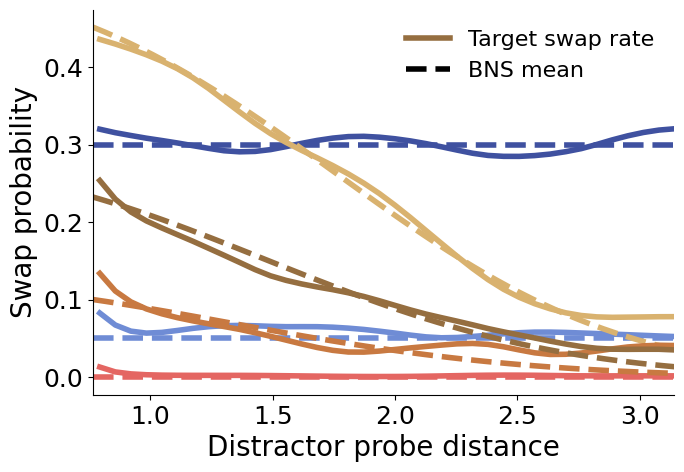

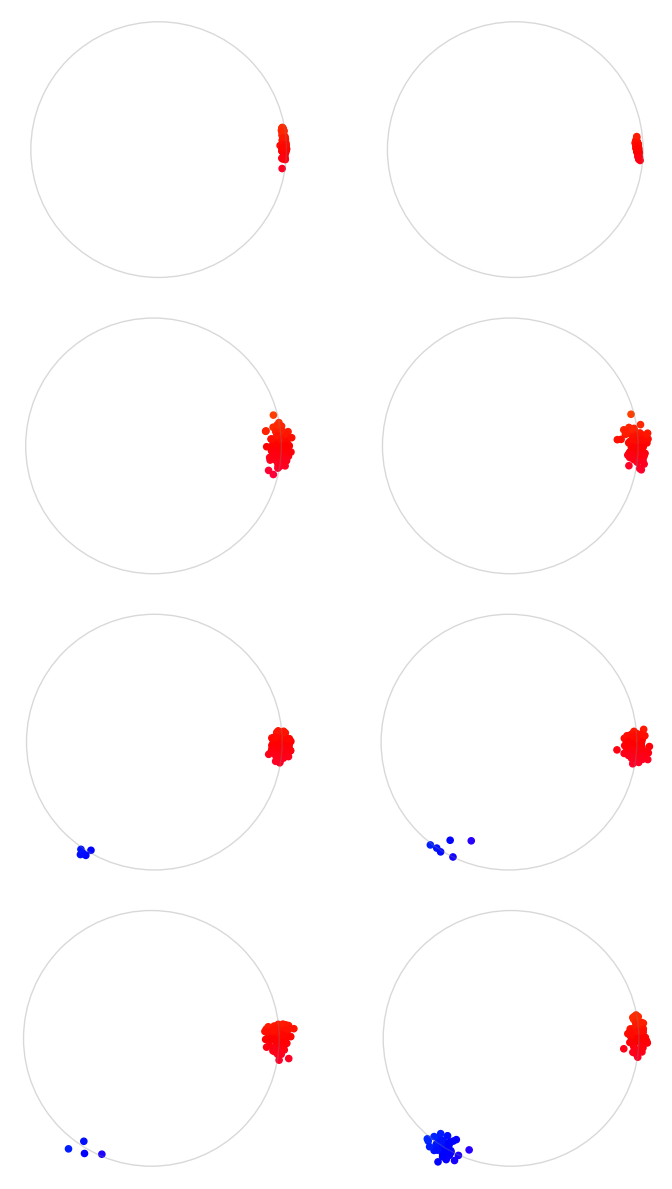

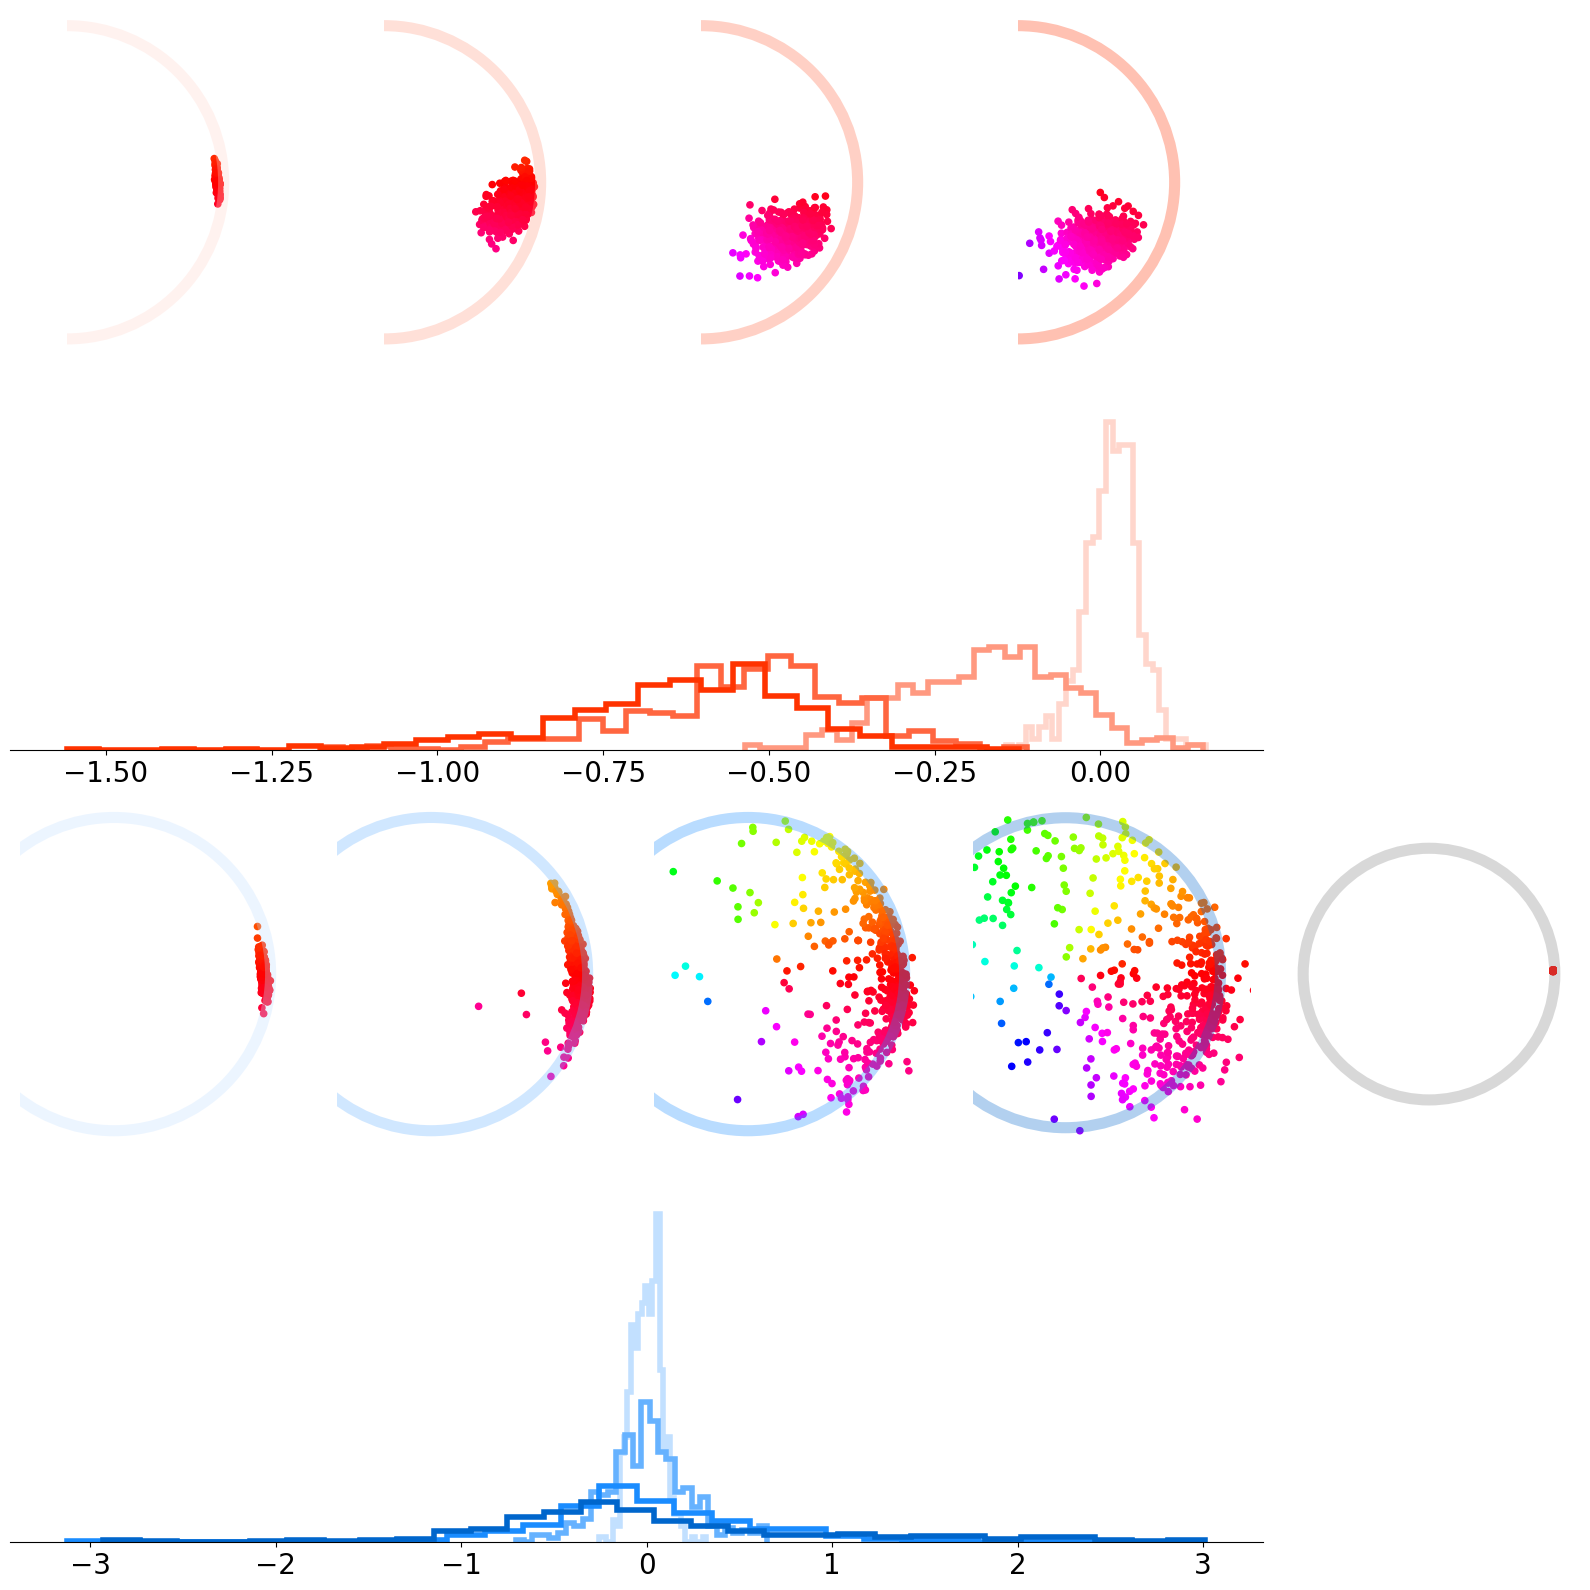

In [22]:
from purias_utils.multiitem_working_memory.util.circle_utils import rot_to_rgb_torch
from purias_utils.util.plotting import lighten_color

est_dim = '#E46662'
cue_dim = '#3F51A0'
full = '#51A3A3'
sns = '#D9B26F'


load_runpaths = {
    'run_a2_probe_cued_rnn_no_swap_1': None,
    # 'run_a4b_probe_cued_diffusion_flat_less_swap_0',
    #'run_a5c_probe_cued_diffusion_cyclical_less_swap_more_1',
    #'run_a5d_probe_cued_diffusion_cyclical_medium_swap_0',
    'run_a3_probe_cued_diffusion_no_swap_1': '#E46662',
    'run_a4_probe_cued_diffusion_flat_swap_1': '#3F51A0',
    'run_a4c_probe_cued_diffusion_flat_even_less_swap_0': '#6F8CD5',
    'run_a5_probe_cued_diffusion_cyclical_swap_1': '#D9B26F',
    'run_a5b_probe_cued_diffusion_cyclical_less_swap_1': '#C87941',
    'run_a5e_probe_cued_diffusion_cyclical_medium_less_swap_0': '#956E40'
}


selected_items = [
    'run_a2_probe_cued_rnn_no_swap_1',
    'run_a3_probe_cued_diffusion_no_swap_1',
    'run_a4c_probe_cued_diffusion_flat_even_less_swap_0',
    'run_a5_probe_cued_diffusion_cyclical_swap_1',
]

selected_item_ablate = [
    ['1', 'A', 0.2, 'run_a2_probe_cued_rnn_no_swap_1', {'generative_noise_factor': 1.0, 'distractor_probe': torch.pi / 6}],
    ['2', 'A', 0.5, 'run_a2_probe_cued_rnn_no_swap_1', {'generative_noise_factor': 1.0, 'distractor_probe': torch.pi / 20}],
    ['3', 'A', 0.75, 'run_a2_probe_cued_rnn_no_swap_1', {'generative_noise_factor': 1.0, 'distractor_probe': torch.pi / 50}],
    ['4', 'A', 1.0, 'run_a2_probe_cued_rnn_no_swap_1', {'generative_noise_factor': 1.0, 'distractor_probe': torch.pi / 100}],

    ['5', 'B', 0.2, 'run_a2_probe_cued_rnn_no_swap_1', {'generative_noise_factor': 2.0, 'distractor_probe': torch.pi / 4}],
    ['6', 'B', 0.5, 'run_a2_probe_cued_rnn_no_swap_1', {'generative_noise_factor': 5.0, 'distractor_probe': torch.pi / 4}],
    ['7', 'B', 0.75, 'run_a2_probe_cued_rnn_no_swap_1', {'generative_noise_factor': 10.0, 'distractor_probe': torch.pi / 4}],
    ['8', 'B', 1.0, 'run_a2_probe_cued_rnn_no_swap_1', {'generative_noise_factor': 15.0, 'distractor_probe': torch.pi / 4}],

    ['C', None, None, 'run_a5_probe_cued_diffusion_cyclical_swap_1', {'generative_noise_factor': 0.0, 'distractor_probe': torch.pi / 4}],
]


fig_xlims = {
    '1': [0.0, 3.0],
    '2': [0.0, 3.0],
    '3': [0.0, 3.0],
    '4': [0.0, 3.0],
    '5': [-1.5, 3.0],
    '6': [-1.5, 3.0],
    '7': [-1.5, 3.0],
    '8': [-1.5, 3.0],
    'C': [-3.0, 3.0],
}

hist_cols = {
    'A': (255/255, 51/255, 0/255, 1.0),
    'B': (0/255, 102/255, 204/255, 1.0)
}


figsize = 5
num_rows = 2
num_cols = 5


fig_line, axes_line = plt.subplots(1, 1, figsize = (1.5 * figsize, 1 * figsize), squeeze = True)
fig_main, axes_main = plt.subplots(len(selected_items), 2, figsize = (2 * (figsize-1), len(selected_items) * (figsize - 2)), squeeze = False)
fig_ablate, axes_ablate = plt.subplot_mosaic(
    '''
    11223344..
    11223344..
    AAAAAAAA..
    AAAAAAAA..
    55667788CC
    55667788CC
    BBBBBBBB..
    BBBBBBBB..
    ''',
    figsize = (16, 16)
)

cirlce_alpha = 0.3

for load_path in load_runpaths:

    rnn, task = get_model_and_task_from_loading_name(load_path)
    color = load_runpaths[load_path]

    if color is not None:
        bns, _ = get_bns_from_task_and_loading_name(load_path, task)

        target_line = generate_target_swap_line(task, task.task_variable_gen.min_sep - 0.)
        axes_line.plot(*target_line, linestyle = '--', linewidth = 4, color = color)

        real_line = generate_actual_swap_line(bns, task.task_variable_gen.min_sep - 0.)
        axes_line.plot(*real_line, color = color, linewidth = 4, label = load_path)


    if load_path in selected_items:

        load_path_index = selected_items.index(load_path)
        close_probe_axes = axes_main[load_path_index, 1]
        far_probe_axes = axes_main[load_path_index, 0]

        samples = generate_example_sample_sets(
            rnn = rnn,
            task = task,
            distractor_probe = torch.pi / 4,
            distractor_report = - torch.pi * 2 / 3,
            generative_noise_factor = 1.0,
            num_samples = 128,
        )['samples']

        sample_colors = rot_to_rgb_torch(torch.arctan2(samples[0, :, 1], samples[0, :, 0]))
        sample_colors = [sc.tolist() for sc in sample_colors]
        close_probe_axes.scatter(samples[0, :, 0], samples[0, :, 1], alpha=1.0, marker = 'o', s=20, c=sample_colors)
        close_probe_axes.add_patch(plt.Circle((0, 0), task.sample_gen.sample_radius, color="gray", alpha = cirlce_alpha, fill=False))
        close_probe_axes.set_aspect('equal')
        for spine in close_probe_axes.spines.values():
            spine.set_visible(False)
        close_probe_axes.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)



        samples = generate_example_sample_sets(
            rnn = rnn,
            task = task,
            distractor_probe = torch.pi,
            distractor_report = - torch.pi * 2 / 3,
            generative_noise_factor = 1.0,
            num_samples = 128,
        )['samples']

        sample_colors = rot_to_rgb_torch(torch.arctan2(samples[0, :, 1], samples[0, :, 0]))
        sample_colors = [sc.tolist() for sc in sample_colors]
        far_probe_axes.scatter(samples[0, :, 0], samples[0, :, 1], alpha=1.0, marker = 'o', s=20, c=sample_colors)
        far_probe_axes.add_patch(plt.Circle((0, 0), task.sample_gen.sample_radius, color="gray", alpha = cirlce_alpha, fill=False))
        far_probe_axes.set_aspect('equal')
        for spine in far_probe_axes.spines.values():
            spine.set_visible(False)
        far_probe_axes.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)


        for (abi_sc, abi_hs, col_lt_factor, ablation_name, ablation_config) in selected_item_ablate:

            if ablation_name == load_path:

                hist_color = lighten_color(hist_cols[abi_hs], col_lt_factor) if abi_hs in hist_cols else 'gray'

                samples = generate_example_sample_sets(
                    rnn = rnn,
                    task = task,
                    distractor_report = - torch.pi * 2 / 3,
                    **ablation_config,
                    num_samples = 512,
                )['samples']

                sample_angles = torch.arctan2(samples[0, :, 1], samples[0, :, 0])
                sample_colors = rot_to_rgb_torch(sample_angles)
                sample_colors = [sc.tolist() for sc in sample_colors]
                axes_ablate[abi_sc].scatter(samples[0, :, 0], samples[0, :, 1], alpha=1.0, marker = 'o', s=20, c=sample_colors)
                axes_ablate[abi_sc].add_patch(plt.Circle((0, 0), task.sample_gen.sample_radius, color=hist_color, linewidth=8, alpha = cirlce_alpha, fill=False))
                for spine in axes_ablate[abi_sc].spines.values():
                    spine.set_visible(False)
                axes_ablate[abi_sc].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)


                axes_ablate[abi_sc].set_xlim(fig_xlims[abi_sc])
                axes_ablate[abi_sc].set_aspect('equal')

                if abi_hs is not None:

                    axes_ablate[abi_hs].hist(sample_angles, 30, density = True, histtype=u'step', linewidth = 4, color = hist_color)

                    axes_ablate[abi_hs].spines['top'].set_visible(False)
                    axes_ablate[abi_hs].spines['right'].set_visible(False)
                    axes_ablate[abi_hs].spines['left'].set_visible(False)

                    axes_ablate[abi_hs].set_yticks([])
                    axes_ablate[abi_hs].tick_params(axis='x', which='major', labelsize=20)




fig_main.tight_layout()
fig_ablate.tight_layout()

axes_line.spines['top'].set_visible(False)
axes_line.spines['right'].set_visible(False)
axes_line.set_xlim(target_line[0][0], target_line[0][-1])


import matplotlib.lines as mlines

target_line = mlines.Line2D([], [], color='#956E40', linestyle='-', linewidth=4, label='Target swap rate')
real_line = mlines.Line2D([], [], color='black', linestyle='--', linewidth=4, label='BNS mean')
axes_line.legend(handles=[target_line, real_line], loc='best', frameon=False, fontsize = 16)


axes_line.set_xlabel('Distractor probe distance', fontsize = 20)
axes_line.set_ylabel('Swap probability', fontsize = 20)
axes_line.tick_params(axis='both', which='major', labelsize=18)
# axes_line.set_ylim(y_bot, y_top)

fig_line.savefig('neurips_figures/behaviour_reprod_line.pdf', transparent = True)
fig_main.savefig('neurips_figures/behaviour_reprod_main.svg', transparent = True)
fig_ablate.savefig('neurips_figures/behaviour_reprod_ablate.svg', transparent = True)

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


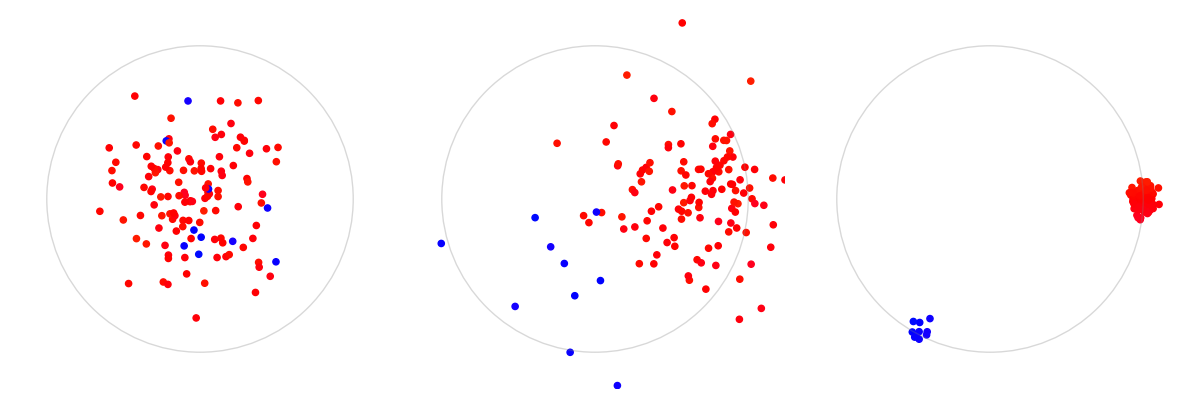

In [6]:
rnn, task = get_model_and_task_from_loading_name('run_a4b_probe_cued_diffusion_flat_less_swap_0')
samples_dict = generate_example_sample_sets(
    rnn = rnn,
    task = task,
    distractor_probe = torch.pi / 4,
    distractor_report = - torch.pi * 2 / 3,
    generative_noise_factor = 1.0,
    num_samples = 128,
)

samples_traj = samples_dict['sample_trajectory']
final_samples = samples_dict['samples']
sample_colors = rot_to_rgb_torch(torch.arctan2(final_samples[0,:,1], final_samples[0,:,0]))
sample_colors = [lighten_color(sc.tolist(), lighten_amounts[i]) for sc in sample_colors]

t_steps = (0, 25, 39 )
fig, axes = plt.subplots(1, len(t_steps), figsize = (len(t_steps) * figsize - 3, 1 * figsize), squeeze = True, sharey = True, sharex = True)



for its, ts in enumerate(t_steps):

    samples_snap = samples_traj[0,:,ts]
    for spine in axes[its].spines.values():
        spine.set_visible(False)
    axes[its].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    
    axes[its].scatter(samples_snap[:,0], samples_snap[:,1], alpha=1.0, marker = markers[i], s=20, c=sample_colors)
    axes[its].add_patch(plt.Circle((0, 0), task.sample_gen.sample_radius / radius_scaler, color="gray", alpha = cirlce_alpha, fill=False))

    axes[its].set_aspect('equal')
    axes[its].set_xlim(-3.1, 3.1)
    axes[its].set_ylim(-3.1, 3.1)

fig.tight_layout()

fig.savefig('neurips_figures/diffusion_traj.svg', transparent = True)